In [2]:
import os, cv2

os.sys.path

['',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python27.zip',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/plat-linux2',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/lib-tk',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/lib-old',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/lib-dynload',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/site-packages',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/site-packages/PIL',
 '/home/users/qiang.lu/anaconda3/envs/tf_gpu/lib/python2.7/site-packages/IPython/extensions',
 '/home/users/qiang.lu/.ipython']









0it [00:00, ?it/s]







1it [00:00,  7.82it/s]

dataset_train is loading..., length = 1
dataset_train type = <type 'instance'>
img_path = /home/users/qiang.lu/FashionAI_datasets/NJ_data/img/01范丹丹/便服（卫衣）/fps0_0.jpg
<unknown>
<dtype: 'uint8'>
processing 0
<type 'numpy.ndarray'>
<type 'instance'>
success


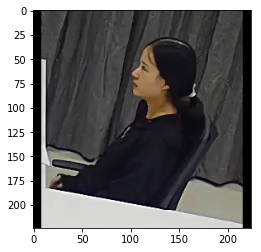

In [43]:
#%%# 载入库模型

import pandas as pd

import os
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib.pyplot import imshow
# from PIL import Image
# import random
# from gluoncv.data.transforms import experimental
#
# # gluon.data.DataLoader
# import matplotlib.pyplot as plt
import cv2

#%%# 定义数据载入类
class DatasetLoader():

    def __init__(self, rootdir, filename, scale=1.0, padding_color='black', transform=None, data_argument=None,
                 input_size=(224, 224), read_type='train'):
        '''
        :param rootdir: 图片的根目录
        :param filename: .txt .csv 等包含种类信息的文件
        :param transform: 数据增强方式，传递进来的是函数
        :param data_argument: 暂时没想好，应该就是数据量扩增
        '''

        self.rootdir = rootdir  #图片的根目录

        datasetInfo = pd.read_csv(filename, header=0, sep=',')#sep='\s+') #pd.read_csv('/data/huayang.liu/Hiscancer/input/train_labels.csv')
        self.datasetInfo = datasetInfo.values #更改数据类型，dataFrame->np array

        self._data_argument = data_argument
        self._transform = transform

        self.items = []
        self.imgFromWhere = []  # 用于处理不同的数据集
        self._get_itemList()#这边时为了获取itemList

        #参数
        self.scale = scale
        self.padding_color = padding_color
        self.input_size = input_size
        self.read_type = read_type


    def __len__(self):
        return len(self.items)


    def _get_itemList(self):

        for example in self.datasetInfo:

            # 获取图片的绝对路径
            abs_path = os.path.join(self.rootdir, example[0])

            # 获取label以及bbox #我这边主要是分类，bbox用于抠图  #category_label color_label x_1	y_1	x_2	y_2
            category_label, color_label, x_1, y_1, x_2, y_2 = example[1], example[2], int(example[3]), \
                                                              int(example[4]), int(example[5]), int(example[6])
            self.items.append((abs_path, [category_label, color_label, x_1, y_1, x_2, y_2]))

            if 'xuzhou_data' in abs_path.split('/'):#XuZhou
                self.imgFromWhere.append(0)
            elif 'DeepFashion1' in abs_path.split('/'):
                self.imgFromWhere.append(1)
            elif 'NJ_data' in abs_path.split('/'):
                self.imgFromWhere.append(2)
            elif 'demo_v1_1024'in abs_path.split('/'):
                self.imgFromWhere.append(3)
            # 这边可以添加尺寸放缩


    def _center_shrinkage(self, x1, y1, x2, y2,img_shape):  #外扩
        #这边应该是要把判断出边界整理好
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        w = w * self.scale
        h = h * self.scale
        x1, x2 = int(cx - w / 2), int(cx + w / 2)
        y1, y2 = int(cy - h / 2), int(cy + h / 2)
        #边界判断
        x1 = x1 if x1 >= 0 else 0
        y1 = y1 if y1 >= 0 else 0
        x2 = x2 if x2 <= img_shape[0] else img_shape[0]
        y2 = y2 if y2 <= img_shape[1] else img_shape[1]
        return x1, y1, x2, y2

    def _get_coordinatesHead(self, x1, y1, x2, y2, img_shape):
        '''
        :param img_shape: 原图尺寸 （,3）
        :return:
        '''
        # 获取高
        H = y2 - y1
        H_head = H / 2.25

        y1 = int(y1 - H_head) if int(y1 - H_head) >= 0 else 0
        return x1, y1, x2, y2


    def __getitem__(self, id):
        img_path = self.items[id][0]
        label = self.items[id][1]
        
        print("img_path = {}".format(img_path))
        
        #filename_queue = tf.train.string_input_producer([img_path])
        
        #reader = tf.WholeFileReader()
        #key, value = reader.read(filename_queue)
        
        #img = tf.image.decode_jpeg(value, channels=3)img
        img  = Image.open(img_path)
        
        img_raw = tf.io.read_file(img_path)
        img_tensor = tf.image.decode_image(img_raw)

        print(img_tensor.shape)
        print(img_tensor.dtype)
        
        #img = mx.image.imread(img_path) # RGB
        img_save = img_tensor
        img_shape = img_tensor.shape  # (256,256,3)
        # import ipdb;
        # ipdb.set_trace()
        # 根据bbox切图
        if self.imgFromWhere[id] == 1:  # 需要将头也框出来 与身体比例 1:2.25
            x1, y1, x2, y2 = self._get_coordinatesHead(x1=label[2], y1=label[3], x2=label[4], y2=label[5],
                                                       img_shape=img_shape)
            x1, y1, x2, y2 = self._center_shrinkage(x1, y1, x2, y2, img_shape)

        elif self.imgFromWhere[id] in [0, 2, 3]:
            x1 = label[2]
            y1 = label[3]
            x2 = label[4]
            y2 = label[5]
            # # 暂时不放缩徐州的图
            # if self.imgFromWhere[id] == 3:
            #     height, weight = y2 - y1, x2 - x1
            #     img = mx.image.fixed_crop(img, x0=x1, y0=y1, h=height, w=weight)
            #     import matplotlib.pyplot as plt
            #     plt.imshow(img.asnumpy()); plt.savefig('test.jpg')
            #     import ipdb;ipdb.set_trace()

        height, weight = y2 - y1, x2 - x1
        #img = mx.image.fixed_crop(img, x0=x1, y0=y1, h=height, w=weight)
        #img = tf.image.crop_and_resize(img, xxxxxx)
        img     = img.crop((x1,y1,x2,y2))
        
        #img.show()

        # 进行填充 https://blog.csdn.net/ei1990/article/details/78350974 https://blog.csdn.net/WYXHAHAHA123/article/details/88092722
        padding_ = height - weight
        color_dict = {'BLACK': [0, 0, 0], 'GREY': [100, 100, 100]}

        if padding_ > 0:
            img = cv2.copyMakeBorder(np.asarray(img), top=0, bottom=0, left=padding_ // 2, right=padding_ - padding_ // 2,
                                     borderType=cv2.BORDER_CONSTANT,
                                     value=color_dict[self.padding_color.upper()])  ##top,bottom,left,right
        elif padding_ < 0:
            padding_ = abs(padding_)
            img = cv2.copyMakeBorder(np.asarray(img), top=padding_ // 2, bottom=padding_ - padding_ // 2, left=0, right=0,
                                     borderType=cv2.BORDER_CONSTANT,
                                     value=color_dict[self.padding_color.upper()])  ##top,bottom,left,right

        # 进行resize,双线性插值
        try:
            img = cv2.resize(img, self.input_size, interpolation=cv2.INTER_LINEAR)
        except:
            img = cv2.resize(np.asarray(img), self.input_size, interpolation=cv2.INTER_LINEAR)

        # import matplotlib.pyplot as plt
        # plt.imshow(img); plt.savefig('test{}.jpg'.format(np.random.random()))
        # import ipdb;ipdb.set_trace()

        #if self._transform is not None:
        #    # import ipdb;ipdb.set_trace()
        #    return self._transform(nd.array(img), np.array(label))

        # if self._read=='cls':
        #     img = experimental.image.random_color_distort(img)
        # import ipdb;ipdb.set_trace()
        if self.read_type.lower() == 'train':
            return np.asarray(img), np.asarray(label)  # , img_save.asnumpy()#, np.str(img_path)  ###########
        if self.read_type.lower() == 'analysis':
            return np.asarray(img), np.asarray(label), np.str(img_path)
        if self.read_type.lower() == 'show':
            return np.asarray(img), np.asarray(label), img_save.asnumpy()#, np.str(img_path)


if __name__ == '__main__':
    from tqdm import tqdm

    # rootDir = '/home/data/Clothes_Datasets/'
    # datasetInfo_train = 'dataset_train_v2_192023.txt'
    # datasetInfo_test = 'dataset_test_v2_192023.txt'

    rootDir = '/home/users/qiang.lu/FashionAI_datasets'

    datasetInfo_train = 'dataset_train_luq_1116_dim13_v1.txt'
    # datasetInfo_test = 'dataset_test.txt'

    dataset_train = DatasetLoader(rootDir, datasetInfo_train, scale=1, padding_color='black',
                                   transform=None, data_argument=False,
                                   input_size=(224, 224), read_type='train')

    #dataset_test = DatasetLoader(rootDir, datasetInfo_test, scale=1, padding_color='black',
    #                             transform=None, data_argument=False,
    #                             input_size=(224, 224), read_type='train')


    print('dataset_train is loading..., length = {}'.format(len(dataset_train)))
    print('dataset_train type = {}'.format(type(dataset_train)))
    
    for i, value in tqdm(enumerate(dataset_train)):
        print("processing {}".format(i))
        print(type(value[0]))
        
        im = Image.fromarray(value[0])
        print(type(im))
        %matplotlib inline
        imshow(np.asarray(im))
    #     pass
    #print('dataset_test is loading...')
    #for i, _ in tqdm(enumerate(dataset_test)):
    #    pass
    print('success')


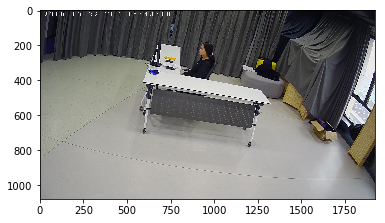

In [42]:
from matplotlib.pyplot import imshow

img_path = "/home/users/qiang.lu/FashionAI_datasets/NJ_data/img/01范丹丹/便服（卫衣）/fps0_0.jpg"

im = Image.open(img_path)

im.show()

%matplotlib inline
imshow(np.asarray(im))


